# AUTHORS: DAVID LAESSKER - PETER FAGRELL

## Part 1

In [232]:
# Imports

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import numpy as np
np.random.seed(0)
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
import os.path
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='logs')

Loading images...

In [233]:
data_gen = ImageDataGenerator(rescale=1.0/255)

img_size = 64
batch_size = 32

def data_generator(dir, data_gen):
    generator = data_gen.flow_from_directory(
        dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)
    return generator

train_generator = data_generator('train', data_gen)
val_generator = data_generator('validation', data_gen)

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


Create train generator

In [234]:
Xbatch, Ybatch = train_generator.next()
randimg = Xbatch[random.randint(0, batch_size-1)]

Show random image in the training data

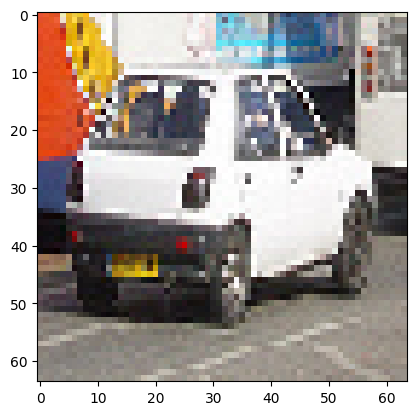

In [235]:
plt.imshow(randimg)

Make convolutional net function :)

In [236]:
def make_convnet(img_width=64, img_height=64, channels=3):
    """
    Creates a convolutional neural network with the specified input shape.
    For binary classification.
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                    activation='relu',
                    input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

Make function for displaying history :)

In [237]:
def display_history(history):
    try:
        history = history.history
    except:
        pass
    fig = plt.figure()
    plt.plot(history['loss'], color='teal', label='loss')
    plt.plot(history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    fig = plt.figure()
    plt.plot(history['accuracy'], color='teal', label='accuracy')
    plt.plot(history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

Mini funct to make code below look better

In [238]:
def model_exists(model): return os.path.isfile('model/' +model)

We use the function to create our model with the specified img_size

In [239]:
epochs = 20 # number of epochs to train for
model = make_convnet(img_width=img_size, img_height=img_size) # Create the model

### If you want to train a new model remove or rename old 'model.h5' file in model folder; If there already is a model it will be loaded

In [240]:
if not model_exists('model.h5'):
    hist = model.fit(train_generator, 
        epochs=epochs,
        validation_data=val_generator,
        batch_size=batch_size,
        callbacks=[tensorboard_callback])
    model.save('model/model.h5')
    np.save('model/history.npy', hist.history)
else:
    model = keras.models.load_model('model/model.h5')
    hist = np.load('model/history.npy', allow_pickle=True).item()

Epoch 1/20
50/50 [==============================] - 15s 276ms/step - loss: 0.6892 - accuracy: 0.5938 - val_loss: 0.6637 - val_accuracy: 0.5747
Epoch 2/20
50/50 [==============================] - 12s 248ms/step - loss: 0.6114 - accuracy: 0.6687 - val_loss: 0.5782 - val_accuracy: 0.7135
Epoch 3/20
50/50 [==============================] - 12s 246ms/step - loss: 0.5340 - accuracy: 0.7500 - val_loss: 0.5547 - val_accuracy: 0.7257
Epoch 4/20
50/50 [==============================] - 11s 222ms/step - loss: 0.4664 - accuracy: 0.7856 - val_loss: 0.5470 - val_accuracy: 0.7257
Epoch 5/20
50/50 [==============================] - 14s 273ms/step - loss: 0.4220 - accuracy: 0.8163 - val_loss: 0.5307 - val_accuracy: 0.7726
Epoch 6/20
50/50 [==============================] - 15s 298ms/step - loss: 0.3849 - accuracy: 0.8306 - val_loss: 0.7231 - val_accuracy: 0.6927
Epoch 7/20
50/50 [==============================] - 16s 313ms/step - loss: 0.3770 - accuracy: 0.8250 - val_loss: 0.5933 - val_accuracy: 0.7552

Plot history

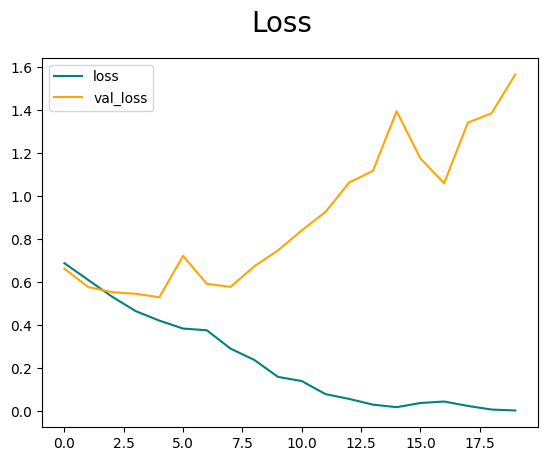

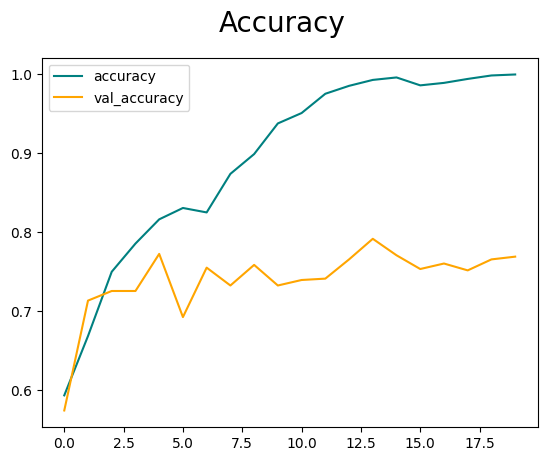

In [241]:
display_history(hist)

## Part 2: Data Augmentation

We used the same code as in Part 1 but with added augmentation in ImageDataGenerator. The augmentation was carefully chosen to not change the images too much. We assume for example that the majority of the images of cars are not upside down. Therefore we do not invert along the X-axis or rotate in any direction more than 30 degrees. We also do not change the brightness or zoom in or out. We do however shift the image in the X and Y direction and flip the image along the Y-axis. This is to make the model more robust to changes in the position of the car in the image.

Found 1600 images belonging to 2 classes.


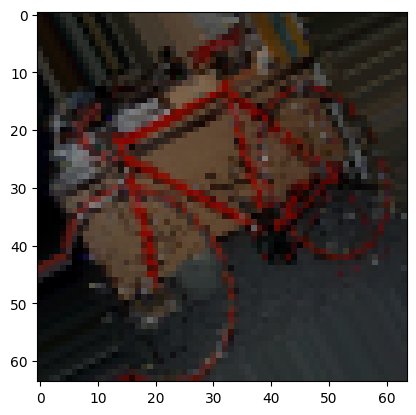

In [242]:
data_gen_aug = ImageDataGenerator(rescale=1.0/255,
                             horizontal_flip=True,
                             brightness_range=[0.5, 1.5],
                             zoom_range=[0.8, 1.2],
                             rotation_range=35,
                             channel_shift_range=10.0,
                             data_format='channels_last'
                             )

aug_train_generator = data_generator('train', data_gen_aug)
aug_gen_X, aug_gen_y = aug_train_generator.next()
randimg = aug_gen_X[random.randint(0, len(aug_gen_X)-1)]
plt.imshow(randimg)

Identical to Part 1 

In [243]:
model = make_convnet(img_width=img_size, img_height=img_size) # Create the model

if not model_exists('model_aug.h5'):
    hist = model.fit(aug_train_generator, 
        epochs=epochs,
        validation_data=val_generator,
        batch_size=batch_size,
        callbacks=[tensorboard_callback])
    model.save('model/model_aug.h5')
    np.save('model/history_aug.npy', hist.history)
else:
    model = keras.models.load_model('model/model_aug.h5')
    hist = np.load('model/history_aug.npy', allow_pickle=True).item()

Epoch 1/20
50/50 [==============================] - 17s 313ms/step - loss: 0.6851 - accuracy: 0.5994 - val_loss: 0.6422 - val_accuracy: 0.6389
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.6950

## Interlude: Pre-trained cnn

Download and apply vggmodel

In [ ]:
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

Predict image
We use a pot in this example and we can see that the vgg model is very sure that it is indeed a pot

1/1 [==============================] - 1s 626ms/step


[[('n03991062', 'pot', 0.9996468),
  ('n03786901', 'mortar', 0.00012746741),
  ('n04049303', 'rain_barrel', 3.8047536e-05),
  ('n04522168', 'vase', 3.2669097e-05),
  ('n04435653', 'tile_roof', 2.9900159e-05)]]

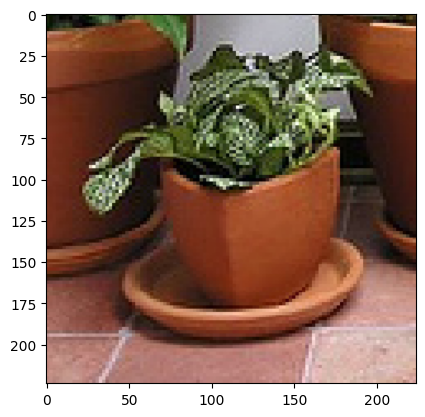

In [ ]:
test_img = load_img('train/other/0200.jpg', target_size=(224, 224))
plt.imshow(test_img)
test_img = img_to_array(test_img)
test_img = preprocess_input(test_img)
test_img = test_img.reshape(1, 224, 224, 3)
decode_predictions(vggmodel.predict(test_img))

## Part 3: Using VGG-16 as a feature extractor

Use code provided

In [ ]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

We crate the data gen and the function creaete_vgg_features taking a directory and a generator as input to extract features using the VGG16 application feature extractor

In [ ]:
data_gen_vgg = ImageDataGenerator(rescale=1.0/255)

create_vgg_features = lambda dir, gen: feature_extractor.predict(gen.flow_from_directory(
    dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'car'],
    seed=12345,
    shuffle=False))

cnn_features_train = create_vgg_features('train', data_gen_vgg)

Found 1600 images belonging to 2 classes.
 4/50 [=>............................] - ETA: 38s

KeyboardInterrupt: 

Save the prediction

In [ ]:
with open('predict.pred', 'wb') as f:
  np.save(f, cnn_features_train)

Code providedProvided de to get labels

In [ ]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

Our Neural network to train on the cnn_features

In [ ]:
def train_on_cnnfeatures():
    model = Sequential()
    model.add(Flatten(input_shape=cnn_features_train.shape[1:]))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [ ]:
with open('predict.pred', 'rb') as f: cnn_features = np.load(f)

In [ ]:
model = train_on_cnnfeatures()
hist = model.fit(cnn_features, get_labels(cnn_features.shape[0]), epochs=epochs, batch_size=batch_size, validation_data=(cnn_features, get_labels(cnn_features.shape[0])))

Epoch 1/5
50/50 [==============================] - 1s 10ms/step - loss: 0.5242 - accuracy: 0.7350 - val_loss: 0.3681 - val_accuracy: 0.8413
Epoch 2/5
50/50 [==============================] - 0s 9ms/step - loss: 0.4124 - accuracy: 0.8169 - val_loss: 0.3199 - val_accuracy: 0.8719
Epoch 3/5
50/50 [==============================] - 0s 9ms/step - loss: 0.3639 - accuracy: 0.8419 - val_loss: 0.2991 - val_accuracy: 0.8744
Epoch 4/5
50/50 [==============================] - 1s 10ms/step - loss: 0.3076 - accuracy: 0.8712 - val_loss: 0.2526 - val_accuracy: 0.8981
Epoch 5/5
50/50 [==============================] - 0s 7ms/step - loss: 0.2833 - accuracy: 0.8869 - val_loss: 0.2478 - val_accuracy: 0.8950


Show history

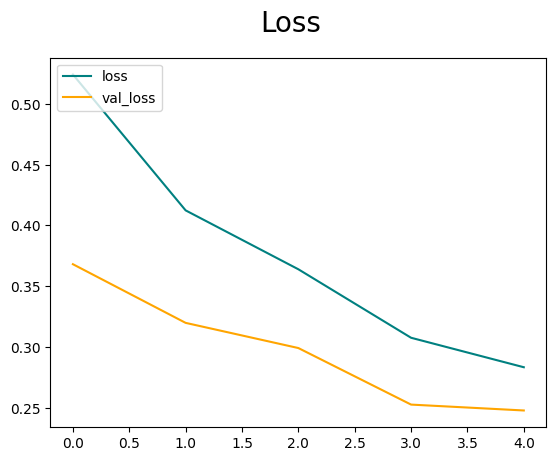

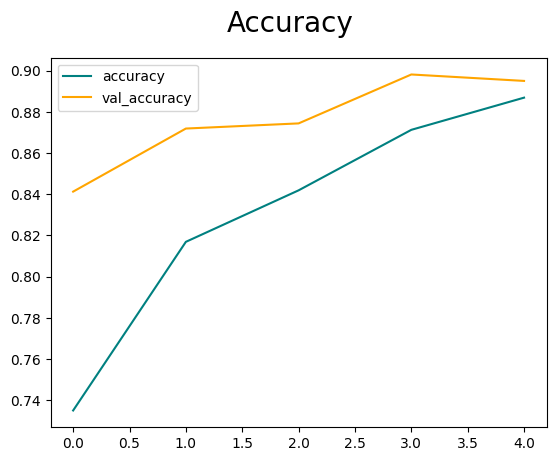

In [ ]:
display_history(hist)

## Part 4: Visualizing the learned features


In [ ]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [ ]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

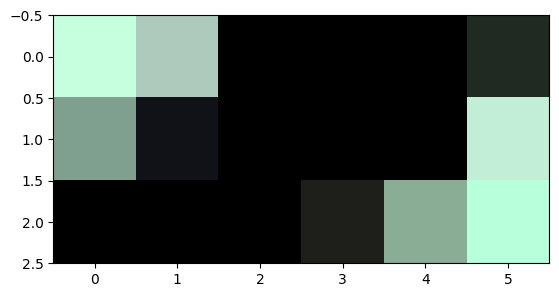

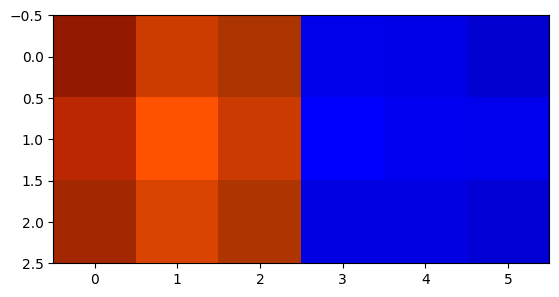

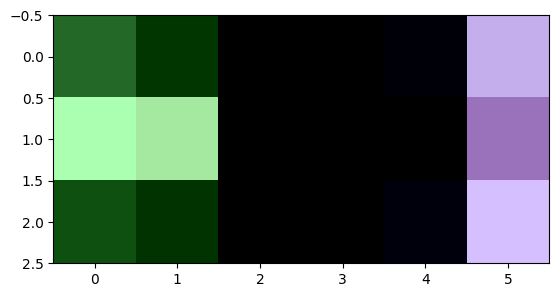

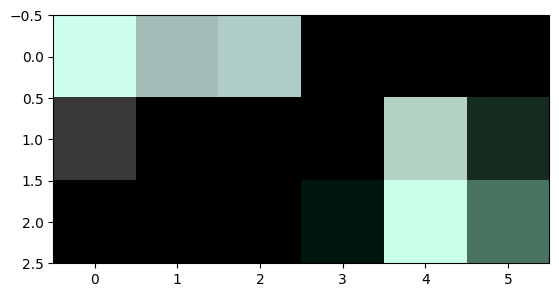

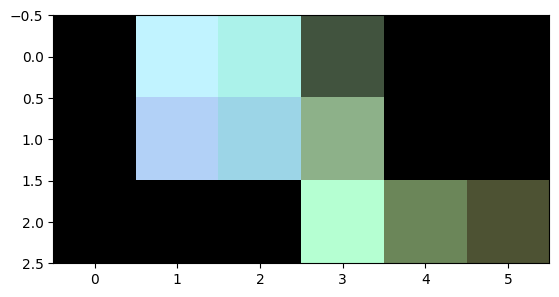

In [ ]:
#visualize the weights of the first layer in pairs

for i in range(0,5):
    img = kernel_image(first_layer_weights, i, True)
    img = np.concatenate((img, kernel_image(first_layer_weights, i, False)), axis=1)
    plt.figure()
    plt.imshow(img)
    plt.show()